# Quantum Transfer Learning
## Based on Pennylane

#### Summary

Purpose: The code classifies images using a hybrid classical-quantum network that utilizes quantum transfer learning.

What is Transfer Learning?
Transfer learning is a machine learning technique in which a pretrained model (source model) on a large dataset is used as a starting point for training a new model for a related task.

Explanation of code:-

ResNet takes in a cropped 244x244 normalized image.

Due to technical limitations of quantum circuits we decided to use a classical convolutional neural network (CNN) to reduce the size of the input data. Using the ResNet18 pretrained network (with frozen weights) we reduced the input image from 244x244 resolution to a vector of size 512. 

A little about ResNet: A residual network, or ResNet for short, is a convolutional neural network that helps to build deeper neural networks by utilizing skip connections or shortcuts to jump over some layers. We are able to load the pretrained version of the network on the images in our dataset and the pretrained network can then classify images into object categories, in our case, into bees and ants. 

After loading ResNet, we used three trainable quantum layers to classify images as images of bees or ants. Since we freeze the classical layers (this means that the weights cannot be modified further so the information contained in them does not change), only the quantum layers can learn the image features and thus, the network's accuracy depends on the quantum layers.


In [1]:
from google.colab import drive # Mount Google Drive to access training data & import pennylane and pytorch for  neural network.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
!pip install --quiet pennylane
import pennylane as qml
from pennylane import numpy as np

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 41.5 MB/s eta 0:00:00


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Set device to GPU if availible else use CPU

In [4]:
# Set Hyperparemeters for neural network
n_qubits = 9                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
num_epochs = 10             # Number of training epochs
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

Since Resnet18 is a pretrained network is has a set input size and shape so we need to transform and normalize training/testing data.

In [5]:
data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "/content/drive/Shareddrives/QML-PeerMentors/Arushi, Rithwik, Noah, Saniya - Quantum Embeddings/Work/_data/hymenoptera_data/"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

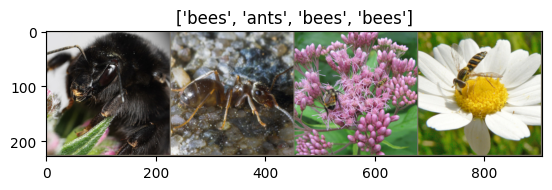

In [6]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# split data into mini-batches to train on
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

The strongly entangled layer is the quantum equivalent of the linear regression layer in classical machine learning. They take in n qubits as inputs, transform each by trainable X,Y, and Z rotations, and then entangle all n qubits with CNOTs.

In [7]:
dev = qml.device("default.qubit", wires=4)
@qml.qnode(dev)
def circuit(weights):
    qml.templates.StronglyEntanglingLayers(weights, wires=[0, 1, 2, 3])
    return qml.expval(qml.PauliX(0))
weight_shape = qml.templates.StronglyEntanglingLayers.shape(n_layers=2, n_wires=4)
weights = np.random.random(weight_shape)
print(qml.draw(circuit, expansion_strategy="device", show_all_wires = True)(weights))

0: ──Rot(0.37,0.95,0.73)─╭●───────╭X──Rot(0.83,0.21,0.18)─╭●────╭X────┤  <X>
1: ──Rot(0.60,0.16,0.16)─╰X─╭●────│───Rot(0.18,0.30,0.52)─│──╭●─│──╭X─┤     
2: ──Rot(0.06,0.87,0.60)────╰X─╭●─│───Rot(0.43,0.29,0.61)─╰X─│──╰●─│──┤     
3: ──Rot(0.71,0.02,0.97)───────╰X─╰●──Rot(0.14,0.29,0.37)────╰X────╰●─┤     


The amplitude embedding converts a classical vector into a quantum state that can be given to a set of qubits (Amplitude embeddings can be used to represent the amplitudes of quantum states as complex numbers, which are then used to classify new quantum states. The information that is stored in the complex numbers defines the state of the qubits, rather than their probabilities.) Amplitude embeddings can represent a classical vector of length 2ⁿ as a quantum state of n qubits. 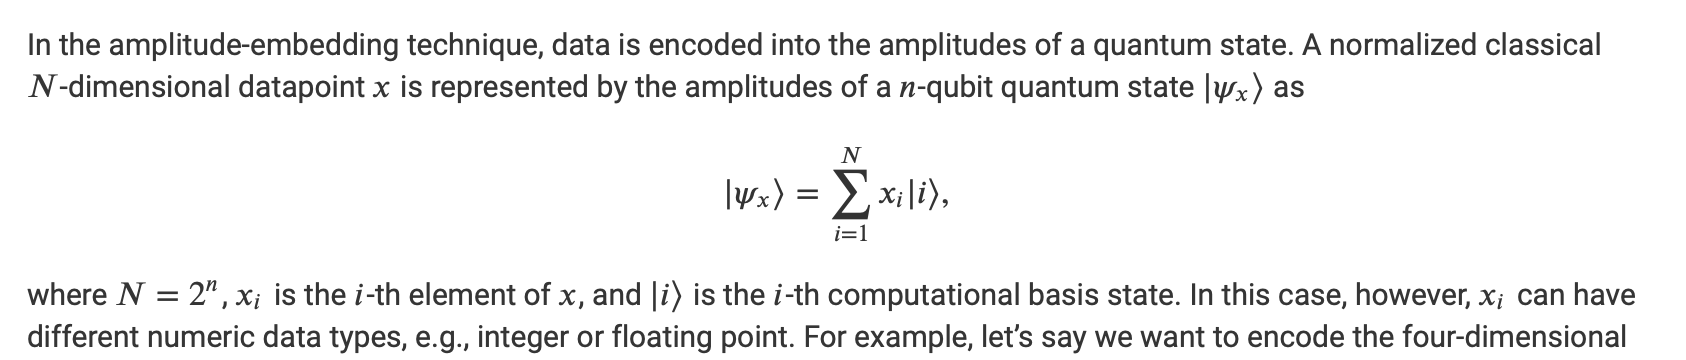

In [8]:
dev = qml.device("default.qubit", wires=4)
@qml.qnode(dev)
def circuit(inputs):
    qml.AmplitudeEmbedding(features=inputs, wires=range(4), normalize=True)
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(4)]
print(qml.draw(circuit, show_all_wires = True)([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]))
print("\n[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16] =>", circuit([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]))

0: ─╭AmplitudeEmbedding(M0)─┤  <Z>
1: ─├AmplitudeEmbedding(M0)─┤  <Z>
2: ─├AmplitudeEmbedding(M0)─┤  <Z>
3: ─╰AmplitudeEmbedding(M0)─┤  <Z>

[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16] => [-0.72727273 -0.36363636 -0.18181818 -0.09090909]


In [9]:
# import the resnet18 pretrained model from pytorch library
model_hybrid = torchvision.models.resnet18(pretrained=True)

# freeze all the weights from resnet18 so won't be trained
for param in model_hybrid.parameters():
    param.requires_grad = False

# create the quantum device for layers
# n_qubits is 9 since 2^9 = 512
n_qubits = 9
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AmplitudeEmbedding(features=inputs, wires=range(9), normalize=True)
    qml.StronglyEntanglingLayers(weights, wires=range(9))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(9)]

# quantum layer with input of 512 output of 9
# quantum layer has a depth of 10
# weight vector signifies (depth, num_qubits, three_rotations:X,Y,Z)
qlayer1 = qml.qnn.TorchLayer(qnode, {"weights": (10, 9, 3) })

# pad_with b/c output 9 and 2^3 only 8 so need 4 qubits rest padded with 0s
@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AmplitudeEmbedding(features=inputs, wires=range(4), normalize=True, pad_with = 0.)
    qml.StronglyEntanglingLayers(weights, wires=range(4))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(4)]

# quantum layer with input of 9 output of 4
# quantum layer has a depth of 8
# weight vector signifies (depth, num_qubits, three_rotations:X,Y,Z)
qlayer2 = qml.qnn.TorchLayer(qnode, {"weights": (8, 4, 3) })

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AmplitudeEmbedding(features=inputs, wires=range(2), normalize=True)
    qml.StronglyEntanglingLayers(weights, wires=range(2))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(2)]

# quantum layer with input of 4 output of 2
# quantum layer has a depth of 6
# weight vector signifies (depth, num_qubits, three_rotations:X,Y,Z)
qlayer3 = qml.qnn.TorchLayer(qnode, {"weights": (6, 2, 3) })

# Notice that model_hybrid.fc is the last layer of ResNet18
# model_hybrid.fc input is a vector of 512 dims
model_hybrid.fc = nn.Sequential(
    qlayer1,
    qlayer2,
    qlayer3
)

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

# design of hybrid model
print(model_hybrid)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 243MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Now, we optimize the model using the Adam optimizer. (Adam is one of the most used optimizers for training deep learning models. It is fast and quite efficient when we have a lot of data for training.)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "train":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model

In [12]:
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

Training started:
Phase: train Epoch: 1/10 Loss: 0.7449 Acc: 0.5246        
Phase: validation   Epoch: 1/10 Loss: 0.7408 Acc: 0.5882        
Phase: train Epoch: 2/10 Loss: 0.7338 Acc: 0.5533        
Phase: validation   Epoch: 2/10 Loss: 0.6953 Acc: 0.5490        
Phase: train Epoch: 3/10 Loss: 0.7468 Acc: 0.5205        
Phase: validation   Epoch: 3/10 Loss: 0.6726 Acc: 0.5752        
Phase: train Epoch: 4/10 Loss: 0.6850 Acc: 0.5984        
Phase: validation   Epoch: 4/10 Loss: 0.6865 Acc: 0.5621        
Phase: train Epoch: 5/10 Loss: 0.6879 Acc: 0.5861        
Phase: validation   Epoch: 5/10 Loss: 0.6840 Acc: 0.6013        
Phase: train Epoch: 6/10 Loss: 0.6617 Acc: 0.6107        
Phase: validation   Epoch: 6/10 Loss: 0.7049 Acc: 0.5163        
Phase: train Epoch: 7/10 Loss: 0.6827 Acc: 0.5984        
Phase: validation   Epoch: 7/10 Loss: 0.6828 Acc: 0.5817        
Phase: train Epoch: 8/10 Loss: 0.6701 Acc: 0.6189        
Phase: validation   Epoch: 8/10 Loss: 0.6611 Acc: 0.5752       

In [13]:
def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

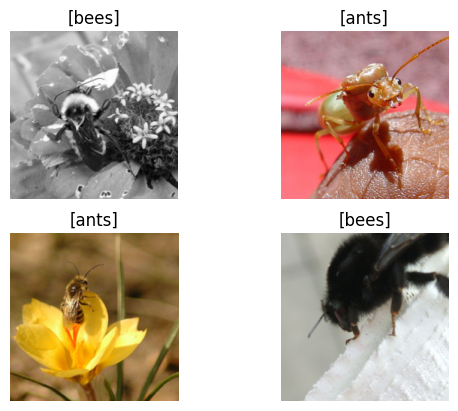

In [15]:
visualize_model(model_hybrid, num_images=batch_size)
plt.show()